API key loaded: True
Base URL: http://localthingbook.io:32081/access/api/driftmind
Created new forecaster with ID: 5c43e71e-136b-49e2-b647-5b28ffdb370f
Starting online learning and forecasting...
⚠️ No forecast available yet
⚠️ No forecast available yet
⚠️ No forecast available yet
⚠️ No forecast available yet
⚠️ No forecast available yet
⚠️ No forecast available yet
⚠️ No forecast available yet
⚠️ No forecast available yet
⚠️ No forecast available yet
⚠️ No forecast available yet
⚠️ No forecast available yet
⚠️ No forecast available yet
⚠️ No forecast available yet
⚠️ No forecast available yet
⚠️ No forecast available yet
Fed Sequence=15, Expected Sin=0.951, Predicted 0.957, SME=0.006
Fed Sequence=15, Expected Cos=-0.571, Predicted -0.617, SME=0.046
Fed Sequence=15, Expected Tan=0.127, Predicted 0.137, SME=0.010
Fed Sequence=16, Expected Sin=0.905, Predicted 0.963, SME=0.058
Fed Sequence=16, Expected Cos=-0.595, Predicted -0.641, SME=0.046
Fed Sequence=16, Expected Tan=0.138, Predicte

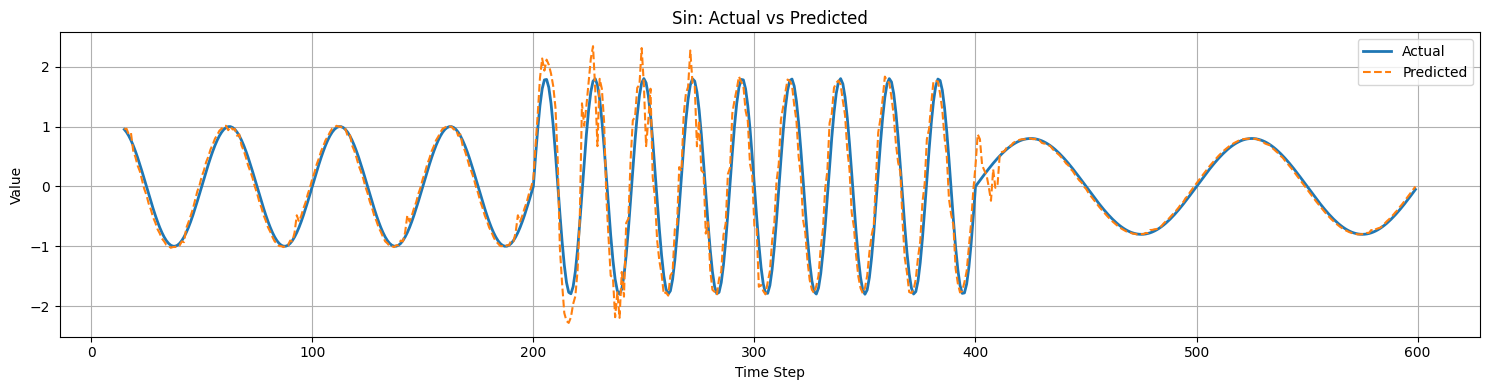

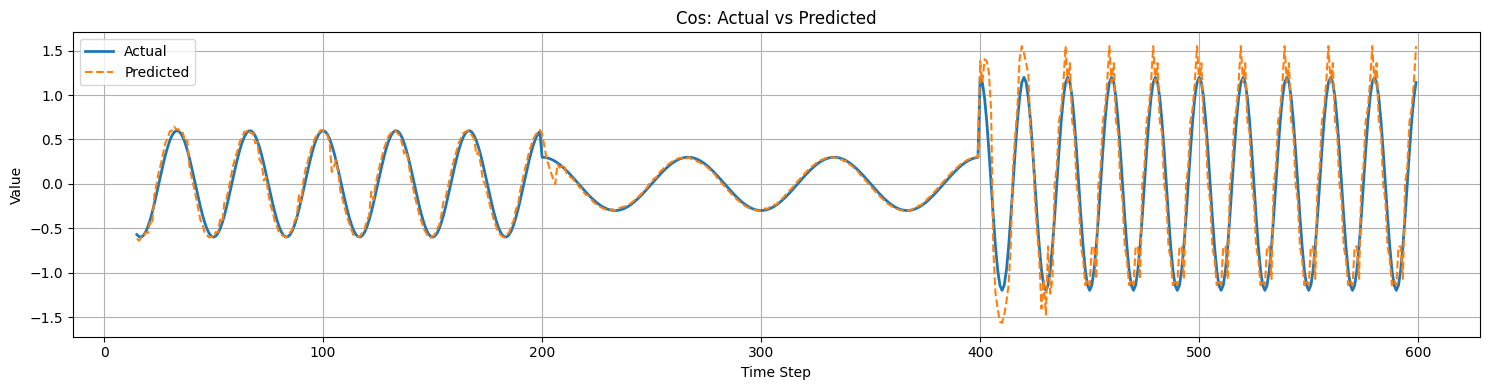

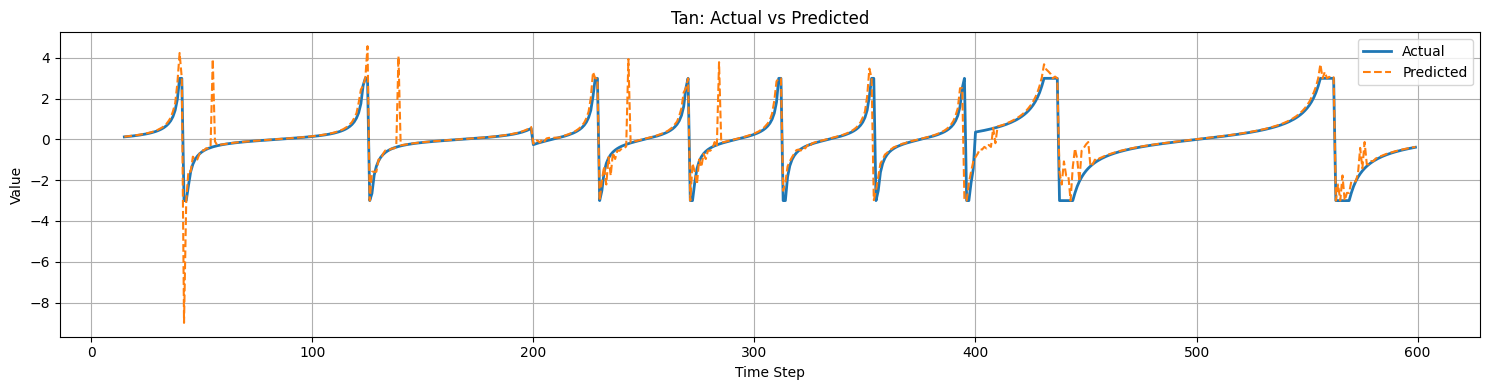

AttributeError: 'list' object has no attribute 'empty'

In [ ]:
from driftmind import DriftMindClient
from driftmind.generator import generate_sin_cos_tan_with_drifts
from driftmind import utils

import pandas as pd
import matplotlib.pyplot as plt

columns = ["Sin", "Cos", "Tan"]
results = {"Sin": [], "Cos": [], "Tan": []}

# 1 Get Credentials
creds = utils.load_credentials()
if creds:
    api_key = creds["DRIFTMIND_API_KEY"]
    base_url = creds["DRIFTMIND_API_URL"]
    print("API key loaded:", bool(api_key))
    print("Base URL:", base_url)
else:
    print("Failed to load DriftMind credentials.")
    exit(1)

# 2. Connect to DriftMind
client = DriftMindClient(api_key, base_url)

# 2. Create fresh forecaster (cold start)
fid = client.create_forecaster({
    "forecasterName": "Cold Start Demo",
    "features":columns,
    "inputSize": 15,
    "outputSize": 1
})["forecaster_id"]

print("Created new forecaster with ID:", fid)

# 3. Generate dataset with drifts
df = generate_sin_cos_tan_with_drifts(n=600)

# 4. Online loop: feed one point → try forecast → store outside the package

print("Starting online learning and forecasting...")
global_results = {"timestamp": [], "anomalyScore": [], "numberOfClusters": []}
for _, row in df.iterrows():
    point = {}
    for col in columns:
        point[col] = [float(row[col])]
    client.feed_point(fid, point)

    yhat = client.forecast(fid)
    if yhat is not None:
        global_results["timestamp"].append(int(row["Sequence"]))
        global_results["anomalyScore"].append(float(yhat.get("anomalyScore", 0)))
        global_results["numberOfClusters"].append(int(yhat.get("numberOfClusters", 0)))
 
        for var in columns:
            feature = yhat.get("FeaturesMap", {}).get(var, {})
            pred = feature.get("predictions", [])
            if pred:
                results[var].append({
                    "expected": float(row[var]),
                    "predicted": float(pred[0]),
                    "timestamp": int(row["Sequence"])
                })
                print(
                    f"Fed Sequence={int(row['Sequence'])}, "
                    f"Expected {var}={float(row[var]):.3f}, "
                    f"Predicted {yhat.get('FeaturesMap', {}).get(var, {}).get('predictions', [0])[0]:.3f}, "
                    f"SME={abs(float(row[var]) - yhat.get('FeaturesMap', {}).get(var, {}).get('predictions', [0])[0]):.3f}"
)



# Visualize results
for var in columns:
    df_var = pd.DataFrame(results[var])
    utils.plot_actual_vs_predicted(df_var, var)

# Visualize global results
df_global = pd.DataFrame(global_results)

utils.plot_time_series(
    df_global["timestamp"],
    df_global["anomalyScore"],
    "Global Anomaly Score over Time",
    "Time Step",
    "Anomaly Score"
)

utils.plot_time_series(
    df_global["timestamp"],
    df_global["numberOfClusters"],
    "Global Number of Clusters over Time",
    "Time Step",
    "Number of Clusters"
)
